### Библиотеки

In [1]:
from data_view import *
from tqdm.notebook import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import statsmodels.api as sm
import os
import re
import boto3
import datetime
import os
from dotenv import load_dotenv
load_dotenv()

session = boto3.session.Session()
s3 = session.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id=os.getenv("YOBJ_ACCESS_KEY"),
    aws_secret_access_key=os.getenv("YOBJ_SECRET_KEY")
)

from jupyterthemes import jtplot
jtplot.style(context='notebook', ticks=True, grid=False)

In [2]:
def get_encoding(f):
    import chardet
    with open(f, 'rb') as f:
        return chardet.detect(f.read())["encoding"]

def dt_split(d):
    try:
        return d[:10] + ' ' + d[10:]
    except:
        return np.nan 

def dt_convert(x, f='%Y-%m-%d %H:%M:%S'):
    try:
        return datetime.datetime.strptime(x, f)
    except Exception as e:
        print(e)
        return np.nan

# функция для отображения гистограммы и боксплота
def histbox(values, figsize=(8, 8), title=None, bins=11, xlabel=None, whis=1.5, 
            flierprops=dict(markerfacecolor='r', marker='s'), boxprops=dict(color='white'), whiskerprops=dict(color='#FFC358'), xlim=None, **kwargs):
    # Построение гистограммы
    fig, ax1 = plt.subplots(figsize=figsize)
    plt.title(title)
    ax1.hist(values, bins=bins, label='Гистограмма', **kwargs)
    ax1.set_xlabel(xlabel)
    ax1.legend()
    ax1.set_xlim(xlim)
    ax1.grid(True)
    ax2 = ax1.twinx()
    
    ax2.boxplot(values, vert=False, whis=whis, notch=True, capprops=whiskerprops, 
                flierprops=flierprops, boxprops=boxprops, whiskerprops=whiskerprops)
    ax2.set_xlim(xlim)
    plt.show()
    
# функция для отображения гистограммы и боксплота
def histbox_qqplot(values, figsize=(8, 8), title=None, bins=11, xlabel=None, whis=1.5, 
            flierprops=dict(markerfacecolor='r', marker='s'), boxprops=dict(color='white'), whiskerprops=dict(color='#FFC358'), xlim=None, **kwargs):
    fig = plt.figure(figsize=figsize, dpi=100)
    ax1 = fig.add_subplot(221)
    ax1.set(title=title)
    # гистограмма и боксплот
    ax1.hist(values, bins=bins, label='Гистограмма', **kwargs)
    ax1.set_xlabel(xlabel)
    ax1.legend()
    ax1.set_xlim(xlim)
    ax1.grid(True, color='grey', linestyle='-', linewidth=0.25)
    ax2 = ax1.twinx()

    ax2.boxplot(values, vert=False, whis=whis, notch=True, capprops=whiskerprops, 
                    flierprops=flierprops, boxprops=boxprops, whiskerprops=whiskerprops)
    ax2.set_xlim(xlim)
    ax3 = fig.add_subplot(222)
    ax3.set(title=title)
    # qqplot
    sm.qqplot(values, line='45', fit=True, ax=ax3)
    ax3.grid(True, color='grey', linestyle='-', linewidth=0.25)
    plt.show()

In [3]:
def base_preprocessing(d):
    # нижний регистр наименований столбцов
    d.columns = [col.lower() for col in d.columns]

    # дропнем дубликаты
    print(f'Размер данных до: {d.shape}')
    d = d.drop_duplicates()
    print(f'Размер данных после: {d.shape}')

    # убираем столбцы, в которых 100% пропусков
    d = d[[col for col in d.columns if d[col].isna().sum() != d.shape[0]]]
    print(f'Размер данных после 100% пропусков: {d.shape}')
    return d

def to_display(d):
    display(HTML(d.to_html()))
    
def obj_list():
    # Получить список объектов в бакете
    for key in s3.list_objects(Bucket='bucket-2-pp')['Contents']:
        print(key['Key'])

def get_obj(link, ends='csv'):
    try:
        # Получить объект
        get_object_response = s3.get_object(Bucket='bucket-2-pp',
                                                Key=link)
        if ends == 'csv':
            return pd.read_csv(get_object_response['Body'], sep=';')
        elif ends in ['xls', 'xlsx']:

            # кодируем объект в таблицу пандас
            return pd.read_excel(io.BytesIO(get_object_response['Body'].read()), encoding='utf-8')
        else:
            return None
    except Exception as e:
        return e
        
from botocore.exceptions import ClientError

def upload_file(file_name, bucket, object_name=None, s3_client=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        print(e)
        return False
    return True

#upload_file('ptl.gzip', bucket='bucket-2-pp', 
#            object_name='ККЦ-ПТЛ(Новая структура)/Часть ПТЛ/Линейная выгрузка по ПТЛ.gzip',s3_client=s3)

In [4]:
def heil(t, n_str=5):
    display(pd.concat([t.head(n_str),t.tail(n_str)], axis=0))
    
# Function to Detection Outlier on one-dimentional datasets.
def find_anomalies(ar, k=1.5):
    p = np.percentile(ar, [25, 75])
    iqr = np.fabs(np.diff(p))[0]
    return ar[(ar <= p[1] + k * iqr) & (ar >= p[0] - k * iqr)], (p[0] - k * iqr, p[1] + k * iqr)

In [5]:
def to_tlg(msg):
    import requests
    url = f"https://api.telegram.org/bot279783998:AAE6cxVCwU97lSbyAu0Af6EWrhpAIUV6wno/sendMessage?chat_id=-155357321&text={msg}"
    try:
        res = requests.get(url)
        return res.status_code
    except Exception as e:
        return str(e)

In [6]:
# complementary colors
color_pairs = [
    ['#381eff', '#ff9a1e'], #0
    ['#c002ff', '#ffdd02'], #1
    ['#99ff00', '#ff0091'], #2
    ['#1eff00', '#ff0015'], #3
    ['#ff4000', '#00ffea'], #4
    ['#ff8400', '#000dff']  #5
]

# triads colors
color_triads = [
    ['#ffff00', '#ff00ff', '#00ffff'], #0
    ['#00ff00', '#ff0000', '#0000ff'], #1
    ['#9900cc', '#00cc99', '#cc9900'], #2
    ['#ff9900', '#9900ff', '#00ff99'], #3
]

# tetra colors
color_tetras = [
    ['#ffff00', '#0000ff', '#ff00ff', '#00ff00'], #0
    ['#00ff00', '#ff00ff', '#ff0000', '#00ffff'], #1
    ['#9900cc', '#33cc00', '#00cc99', '#cc0033'], #2
    ['#ff9900', '#0066ff', '#9900ff', '#66ff00'], #3
]

import matplotlib._color_data as mcd
colors = list(dict(mcd.TABLEAU_COLORS).values())

In [7]:
from sqlalchemy import create_engine

db_config = {'user': 'psqlad',
             'pwd': 'W11Ca',
             'host': 'localhost',
             'port': 5432,
             'db': 'erg'}

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                            db_config['pwd'],
                                                            db_config['host'],
                                                            db_config['port'],
                                                            db_config['db']), client_encoding='utf-8')

## Feature selection

In [8]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.datasets import load_breast_cancer

In [9]:
f = '/Users/admin/Downloads/urev/scripts/ml_datasets/titanic/train.csv'

In [10]:
d = pd.read_csv(f, sep=',', index_col=0)

In [11]:
heil(d)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [12]:
data = {
    'data': d.drop('Survived', axis=1).values,
    'target': d['Survived'].values,
    'target_name': 'Survived',
    'feature_names': d.drop('Survived', axis=1).columns
}

In [13]:
target_feature = data['target_name']

In [14]:
import json

In [15]:
with open('/Users/admin/Downloads/titanic_columns.json', 'w') as f:
    f.write(json.dumps({col: [str(d.reset_index()[col].dtype), col] for col in d.reset_index().columns}))

In [16]:
with open('/Users/admin/Downloads/titanic.json', 'w') as f:
    f.write(json.dumps(d.reset_index().to_dict('records')))

In [17]:
df = pd.DataFrame(data=data['data'], columns=data['feature_names'])\
    .assign(target=data['target'])

In [18]:
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,target
0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,NaN,S,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,1
2,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,NaN,S,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S,1
4,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,NaN,S,0


<hr style="border: 2px solid green;" />

In [19]:
data_structure = {
    'data': d,
    'target_name': 'Survived',
    'feature_names': d.drop('Survived', axis=1).columns,
    'descr': 'Description'
}

In [47]:
# тут прописать импорт необходимых библиотек
import pandas as pd

class ShareNans():
    __doc__ = """
    ShareNans - nans percentage selection method
    param:
     - thr_nulls = float (0-1) - is percent of nans values of column
    
    methods:
     - fit(data) - вычисляет процент пропусков для каждого столбца, на вход подается data структура (описание выше)
     - fit_transform(data) - обучает модель и возвращает dataframe, содержащий selected_columns
     
    attributes:
     - selected_columns_ - отобранные методом признаки
     - advanced_info_ - словарь, ключи - признаки в переданных данных, значения - вычисленная статистика метода
    """
    def __init__(self, thr_nulls=0.1):
        self.thr_nulls = thr_nulls
        self.selected_columns_ = []
        self.advanced_info_ = {}

    def fit(self, data):
        self.advanced_info_ = {col: data['data'][col].isna().sum() / data['data'].shape[0] for col in data['data'].columns}
        self.selected_columns_ = [col for col in self.advanced_info_.keys() if self.advanced_info_[col] <= self.thr_nulls]

    def fit_transform(self, data):
        self.fit(data)
        return data[self.selected_columns_]


# выполнять только для определенного набора признаков, нельзя для категориальных признаков
class ShareUniq():
    __doc__ = """
    ShareUniq - uniq percentage selection method
    param:
     - thr_nunique = float (0-1) - is percent of uniq values of column
    
    methods:
     - fit(data) - вычисляет процент пропусков для каждого столбца, на вход подается data структура (описание выше)
     - fit_transform(data) - обучает модель и возвращает dataframe, содержащий selected_columns
     
    attributes:
     - selected_columns_ - отобранные методом признаки
     - advanced_info_ - словарь, ключи - признаки в переданных данных, значения - вычисленная статистика метода
    """
    def __init__(self, thr_nunique=0.9):
        self.thr_nunique = thr_nunique
        self.selected_columns_ = []
        self.advanced_info_ = {}

    def fit(self, data):
        self.advanced_info_ = {col: data['data'][col].nunique() / data['data'].shape[0] for col in data['data'].columns}
        self.selected_columns_ = [col for col in self.advanced_info_.keys() if self.advanced_info_[col] >= self.thr_nunique]

    def fit_transform(self, data):
        self.fit(data)
        return data[self.selected_columns_]


class SelectByCorr():
    def __init__(self, thr_corr_pair=0.25, thr_corr_with_target=0.5):
        self.thr_corr_pair = thr_corr_pair
        self.thr_corr_with_target = thr_corr_with_target
        self.selected_columns_ = []
        self.advanced_info_ = {}

    def fit(self, data, **kwargs):
        corr_selection_result = data['data'].corr(**kwargs)\
            .unstack()\
            .reset_index()\
            .rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'corr_abs'})\
            .assign(corr_abs = lambda row: row['corr_abs'].map(np.fabs))\
            .assign(is_target = lambda row: (row['feature_1'] == data['target_name']).astype(int))\
            .query("corr_abs!=1")\
            .query("(corr_abs > @self.thr_corr_with_target and is_target==1) or (corr_abs < @self.thr_corr_pair and is_target==0)")
        
        self.advanced_info_ = corr_selection_result
        self.selected_columns_ = list(set(corr_selection_result['feature_1']) & set(corr_selection_result['feature_2']) - set([data['target_name']]))

    def fit_transform(self, data):
        self.fit(data)
        return data[self.selected_columns_]

In [36]:
sn = ShareNans(0.01)

In [37]:
sn.fit(data_structure)

In [39]:
sn.advanced_info_

{'Survived': 0.0,
 'Pclass': 0.0,
 'Name': 0.0,
 'Sex': 0.0,
 'Age': 0.19865319865319866,
 'SibSp': 0.0,
 'Parch': 0.0,
 'Ticket': 0.0,
 'Fare': 0.0,
 'Cabin': 0.7710437710437711,
 'Embarked': 0.002244668911335578}

In [40]:
sn.selected_columns_

['Survived',
 'Pclass',
 'Name',
 'Sex',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Embarked']

### ShareUniq

In [43]:
su = ShareUniq(0.9)
su.fit(data_structure)
display(su.advanced_info_)
display(su.selected_columns_)

{'Survived': 0.002244668911335578,
 'Pclass': 0.003367003367003367,
 'Name': 1.0,
 'Sex': 0.002244668911335578,
 'Age': 0.09876543209876543,
 'SibSp': 0.007856341189674524,
 'Parch': 0.007856341189674524,
 'Ticket': 0.7643097643097643,
 'Fare': 0.2783389450056117,
 'Cabin': 0.16498316498316498,
 'Embarked': 0.003367003367003367}

['Name']

### SelectByCorr

In [53]:
sbc = SelectByCorr(0.25, 0.25)
sbc.fit(data_structure, method='spearman')
display(sbc.advanced_info_)
display(sbc.selected_columns_)

,feature_1,feature_2,corr_abs,is_target
1,Survived,Pclass,0.339668,1
5,Survived,Fare,0.323736,1
9,Pclass,SibSp,0.043019,0
10,Pclass,Parch,0.022801,0
12,Age,Survived,0.052565,0
15,Age,SibSp,0.182061,0
17,Age,Fare,0.135051,0
18,SibSp,Survived,0.088879,0
19,SibSp,Pclass,0.043019,0
20,SibSp,Age,0.182061,0


['Age', 'Fare', 'SibSp', 'Pclass', 'Parch']

<hr style="border: 2px solid green;" />

## 1 Методы фильтрации
### 1.1 Доля пропусков

In [ ]:
thr_nulls = 0.1

In [ ]:
col_1_1 = [col for col in data['feature_names'] 
           if df[col].isna().sum() < thr_nulls * data['data'].shape[0]]

In [ ]:
col_1_1

### 1.2 Доля уникальных значений

In [ ]:
# доля уникальных значений
thr_nunique = 0.1

In [ ]:
print(f"N features {df.set_index(['target']).shape[1]}")

In [ ]:
col_1_2 = [col for col in df.set_index(['target']).columns if df[col].nunique()/df.shape[0] > thr_nunique]

In [ ]:
print(f"N features {df.set_index(['target'])[col_1_2].shape[1]}")

In [ ]:
col_1_2 = df.drop('target', axis=1).columns.to_list()

### 1.3 Correlation-based feature selection

In [ ]:
invertedRdBu = [[0, "rgb(178,10,28)"], [.35, "rgb(230,145,90)"], [.5, "rgb(220,170,132)"], [.6, "rgb(190,190,190)"], [.7, "rgb(106,137,247)"], [1, "rgb(5,10,172)"]]

In [ ]:
corr = df[col_1_2 + ['target']].corr()

In [ ]:
fig = go.Figure(data=[go.Heatmap(z=corr, colorscale=invertedRdBu[::-1], x=corr.columns, y=corr.columns)])
fig.update_layout(
        title =  dict(text='Корреляции',
                               font =dict(color = 'white')),
        height=960,
        width=1080,
        plot_bgcolor="rgba(0, 0, 0, 0)",
        paper_bgcolor="rgba(0, 0, 0, 0)"
    )
fig.update_xaxes(title_font=dict(color='white'), tickcolor='white', tickfont=dict(color='white'), gridwidth=1, gridcolor='grey')
fig.update_yaxes(title_font=dict(color='white'), tickcolor='white', tickfont=dict(color='white'), gridwidth=1, gridcolor='grey')
fig.show()

In [ ]:
thr_corr_pair = 0.25
thr_corr_with_target = 0.5

In [ ]:
corr_selection_result = corr\
    .unstack()\
    .reset_index()\
    .rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'corr_abs'})\
    .assign(corr_abs = lambda row: row['corr_abs'].map(np.fabs))\
    .assign(is_target = lambda row: (row['feature_1'] == 'target').astype(int))\
    .query("corr_abs!=1")\
    .query("(corr_abs > @thr_corr_with_target and is_target==1) or (corr_abs < @thr_corr_pair and is_target==0)")
corr_selection_result

In [ ]:
col_1_3 = set(corr_selection_result['feature_1']) & set(corr_selection_result['feature_2']) - set(['target'])

In [ ]:
print(f"N features {df.set_index(['target'])[col_1_3].shape[1]}")

### 1.4 Соотношение дисперсий

In [ ]:
def dispersion(data):
    data = data +1 #avoid 0 division
    aritmeticMean = np.mean(data, axis =0 )
    geometricMean = np.power(np.prod(data, axis =0 ),1/data.shape[0])
    R = aritmeticMean/geometricMean
    return R

In [ ]:
R = dispersion(df.drop('target', axis=1))

In [ ]:
R

In [ ]:
col_1_4 = []

#### 1.5 Отбор критерием $\chi^2$

In [103]:
from sklearn.feature_selection import chi2, f_regression
from sklearn.preprocessing import MinMaxScaler
import numpy as np

class SelectByMethod():
    __doc__ = """Doc string"""
    
    def __init__(self, thr_alpha=0.1, fillna=True, only_numeric_features=True, model='classification', scaler_for_chi_squared=None):
        self.thr_alpha=thr_alpha
        self.fillna=fillna
        self.only_numeric_features=only_numeric_features
        self.model=thr_alpha
        self.scaler_for_chi_squared=scaler_for_chi_squared
        self.selected_columns_ = []
        self.advanced_info_ = {}
        
    def fit(self, data, fill_value=9999):
        X, y = data['data'][data['feature_names']], data['data'][data['target_name']]
        
        if self.fillna:
            X = X.fillna(fill_value)
        else:
            X = X.dropna()
            y = y[X.index]
            
        if self.only_numeric_features:
            X = X.select_dtypes(np.number)
            
        self.X_columns_ = X.columns
            
        if self.scaler_for_chi_squared:
            X = self.scaler_for_chi_squared.fit_transform(X)
            
        if self.model == 'classification':
            scores = chi2(X,y)
        else:
            scores = f_regression(X,y)
        self.advanced_info_ = {col: score for col, score in zip(self.X_columns_ , scores[1])}
        self.selected_columns_ = [col for col, score in zip(self.X_columns_ , scores[1]) if score <= thr_alpha]

In [104]:
chi = SelectByMethod(thr_alpha=0.1, fillna=True, only_numeric_features=True,
                     model='classification', scaler_for_chi_squared=MinMaxScaler((0, 1)))

In [105]:
chi.fit(data_structure)

In [106]:
display(chi.advanced_info_)
display(chi.selected_columns_)

{'Pclass': 2.537047387980997e-25,
 'Age': 0.005764890959228183,
 'SibSp': 0.29224392869817906,
 'Parch': 0.0147992453747224,
 'Fare': 6.120189341921873e-15}

['Pclass', 'Age', 'Parch', 'Fare']

In [55]:
# преобразование отрицательных признаков
min_max_sc = MinMaxScaler((0, 1))

In [58]:
X, y = df.drop('target', axis=1).fillna(9999).select_dtypes(np.number), df['target']

In [59]:
X_min_max_sc = min_max_sc.fit_transform(X)

In [64]:
chi_scores = f_regression(X_min_max_sc,y)

In [71]:
{col: score for col, score in zip(X.columns, chi_scores[1])}

{'Pclass': 1.8036018463381582e-07,
 'Age': 0.014364818799103804,
 'SibSp': 0.5699697196703628,
 'Parch': 0.194537366143567,
 'Fare': 0.00298081971968041}

In [65]:
thr_alpha = 0.1
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values_kbest = p_values[p_values < thr_alpha].sort_values(ascending = False )

In [68]:
p_values

Pclass    1.803602e-07
Age       1.436482e-02
SibSp     5.699697e-01
Parch     1.945374e-01
Fare      2.980820e-03
dtype: float64

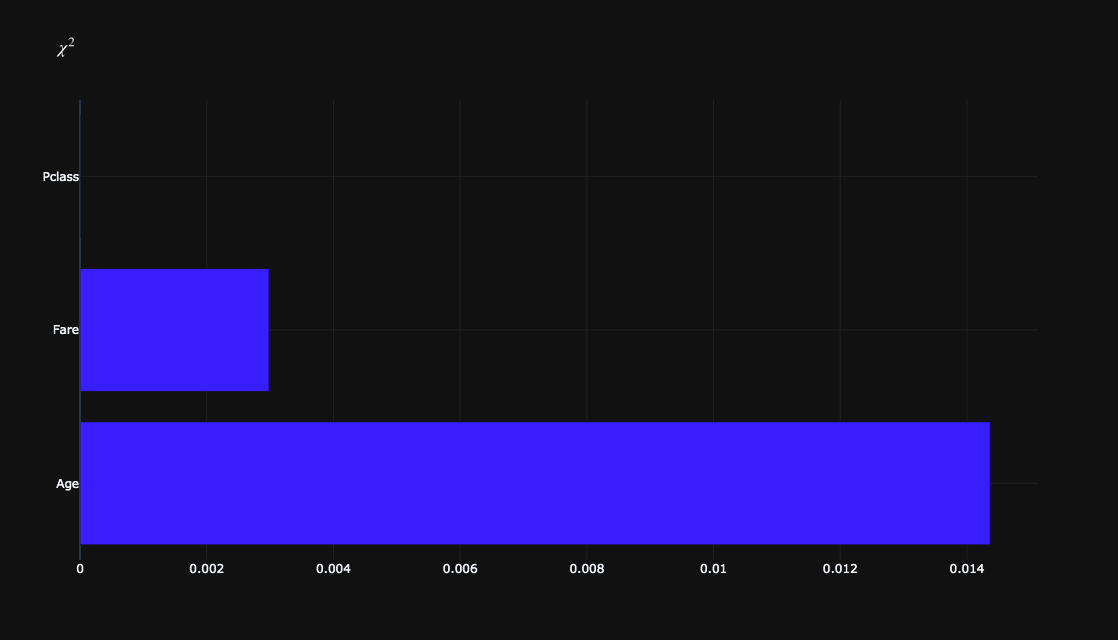

In [66]:
fig = go.Figure(data=[go.Bar(x=p_values_kbest.values, y=p_values_kbest.index, orientation='h', marker=dict(color=color_pairs[0][0]), name='Pvalue')])
fig.update_layout(
            title =  dict(text=f'$\chi^2$',
                                   font =dict(color = 'white')),
            height=640,
            width=960,
            xaxis_title='',
            yaxis_title='',
            template='plotly_dark'
        )
fig.update_xaxes(gridwidth=0.25, gridcolor='#4f4d4c')
fig.update_yaxes(gridwidth=0.25, gridcolor='#4f4d4c')
fig.show()

In [ ]:
# набор признаков после второго отбора по Хи квадрат критерию
col_1_5 = p_values_kbest.index.tolist()

In [ ]:
print(f"Отобрано N features {df[col_1_5].shape[1]}")

In [ ]:
df[col_1_5].shape

In [ ]:
df[c].head()

## 2 Wrappers method
### 2.1 Отбор пар признаков, наилучшим образом разделяющих выборку

In [ ]:
from itertools import permutations
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, mean_absolute_error

Здесь нужен выбор - **Какая задача решается, то и делать**

In [ ]:
scores = []
for pair in tqdm(permutations(df.drop(target_feature, axis=1), 2), desc='Pair loop: '):
    X = df[[col for col in pair]]
    sc = StandardScaler()
    X_sc = sc.fit_transform(X)
    m = LogisticRegression()
    m.fit(X_sc, df[target_feature])
    y_preds = m.predict(X_sc)
    scores+=[['-'.join(pair), f1_score(df[target_feature], y_preds)]]

In [ ]:
scores = []
for feature in tqdm(df.drop(target_feature, axis=1).columns, desc='Pair loop: '):
    X = df[[feature]].fillna(9999)
    m = RandomForestRegressor(random_state=88, n_estimators=10, n_jobs=-1)
    m.fit(X, df[target_feature])
    y_preds = m.predict(X)
    scores+=[['-'.join([feature]), mean_absolute_error(df[target_feature], y_preds)]]

In [ ]:
scores = pd.DataFrame(data=scores, columns=['pair', 'score'])

In [ ]:
scores

In [ ]:
# если не задан порог вручную, то используется доля большего класса или среднее значение в случае регрессии
thr_score_manual = 0.05
thr_score = thr_score_manual if thr_score_manual else df[target_feature].mean()
thr_score

In [ ]:
pair_selection = scores[(scores['score'] < thr_score)]

In [ ]:
pair_selection.shape

In [ ]:
col_2_1 = list(set(pair_selection['pair'].str.split('-', expand=True)[0].unique().tolist() + pair_selection['pair'].str.split('-', expand=True)[1].unique().tolist()))

In [ ]:
col_2_1 = pair_selection['pair'].unique().tolist()

In [ ]:
col_2_1

## 3
### 3.1 Boruta

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [ ]:
X, y = df.drop(target_feature, axis=1).fillna(9999), df[target_feature]

In [ ]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestRegressor(n_jobs=-1, max_depth=5, max_features=10)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X.values, y)

In [ ]:
feature_df = pd.DataFrame(X.columns.tolist(), columns=['features'])
feature_df['rank']=feat_selector.ranking_
feature_df = feature_df.query("rank <= 5").sort_values('rank', ascending=True).reset_index(drop=True)

In [ ]:
data = [go.Bar(y=feature_df['features'], x=feature_df['rank'], orientation='h')]
fig = go.Figure(data=data)
fig.update_layout(
    title="Boruta ranks",
    height=640,
    width=640,
    xaxis_title='Rank',
    yaxis_dtick=1,
    template='plotly_dark'
)
fig.show()

In [ ]:
len(col_best_split), feature_df['features'].shape[0]

In [ ]:
col_3_1 = feature_df['features'].to_list()

### 3.2 Predictive Power Score

In [ ]:
import ppscore as pps

In [ ]:
df_target_str = df.assign(target=lambda row: row[target_feature].map(float))

In [ ]:
feature_pps = pps.predictors(df_target_str, target_feature, sorted=True).query("model_score <= baseline_score")

In [ ]:
feature_pps.head()

In [ ]:
col_3_2 = feature_pps['x'].to_list()

### Что берем из всех отборов

In [ ]:
names = ['Nans share', 'Unique share', 'Corr', 'VIF', 'Chi^2', 'RF best split', 'Boruta', 'PPS']

In [ ]:
selection_funnel = []
for idx, (cols, name) in enumerate(zip([col_1_1, col_1_2, col_1_3, col_1_4, col_1_5, col_2_1, col_3_1, col_3_2], names)):
    if cols != []:
        selection_funnel.append([idx+1, len(cols), name])

In [ ]:
ar_selection_funnel = pd.DataFrame(data=selection_funnel, columns=['idx', 'cnt', 'name']).sort_values(by='idx', ascending=False)

In [ ]:
ar_selection_funnel

In [ ]:
data = [go.Bar(x=ar_selection_funnel['cnt'], y=ar_selection_funnel['name'], orientation='h')]
fig = go.Figure(data=data)
fig.update_layout(
    title="Feature Selected funnel",
    height=480,
    width=640,
    xaxis_title='Кол-во отобранных признаков',
    yaxis_title='Метод отбора',
    yaxis_type='category',
    yaxis_dtick=1,
    template='plotly_dark'
)
fig.show()

In [ ]:
# выбираем признаки по chi^2
selected_columns = col_1_5

### Моделирование

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
SEED = 88

In [ ]:
models = []
params = []

rf = RandomForestRegressor(random_state=SEED)
params_rf = {'max_features': ['sqrt', 'log2', None],
             'n_estimators': [*range(10, 101, 10)],
             'max_depth': [np.ceil(np.log(len(selected_columns))), np.ceil(np.sqrt(len(selected_columns))), None]
            }

models.append(rf)
params.append(params_rf)
"""
logit = LogisticRegression(random_state=SEED, solver='liblinear')
params_logit = {'C': np.logspace(-2, 1, 10)}

models.append(logit)
params.append(params_logit)
"""

In [ ]:
cv = TimeSeriesSplit(n_splits=3)

In [ ]:
def sel_best_model(model, params, X, y, cv, **kwargs):
    """
    Находит наилучшие параметры для модели
    
    :param model: модель машинного обучения    
    :param params: массив комбинаций параметров, из которых будет выбираться лучшая модель
    :param X: признаки для обучения
    :param y: целевая переменная
    :param cv: настройки кросс-валидации
    
    :return: наилучшая модель и score этой модели
    
    """
    clf = RandomizedSearchCV(model, params, cv=cv, refit=True, n_jobs=-1, random_state=SEED, **kwargs)
    clf.fit(X, y)
    
    score_table = {
        'model': [type(model).__name__],
        'mean_fit_time': [clf.cv_results_['mean_fit_time'][clf.best_index_]],
        'mean_test_score': [clf.best_score_],
        'std_test_score': [clf.cv_results_['std_test_score'][clf.best_index_]],
        'params': [clf.best_params_]
    }
    
    score_table = pd.DataFrame(score_table)
    best_model = clf.best_estimator_
    
    return best_model, score_table

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[selected_columns], df['target'], test_size=0.3, random_state=SEED, shuffle=False)

In [ ]:
pd.options.display.max_colwidth = -1

In [ ]:
%%time
best_scores = []
best_models = []

for m, p in zip(models, params):
    best_estimator, best_score = sel_best_model(m, p, X_train, y_train, cv, scoring=None)
    best_scores.append(best_score)
    best_models.append(best_estimator)
    
results = pd.concat(best_scores).reset_index(drop=True).rename(columns={'mean_test_score': 'mean_test_score'})
results

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, best_models[0].predict_proba(X_test)[:,1], pos_label=1)
lw = 2

data = [
    go.Scatter(x=fpr, y=tpr, name='ROC curve'),
    go.Scatter(x=[0, 1], y=[0, 1], name='Random curve')
]

In [ ]:
fig = go.Figure(data=data)
fig.update_layout(
    title="ROC curve",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    width=960,
    height=640,
    legend_itemsizing='trace',
    template='plotly_dark'
)
fig.show()

### Оценка признаков

In [ ]:
feature_importances = pd.Series(best_models[0].feature_importances_).to_frame(name='value')\
    .assign(feature=selected_columns)\
    .sort_values(by='value', ascending=False)\
    .assign(cumulative_value=lambda row: row['value'].cumsum())\
    .head(15)

In [ ]:
fig = go.Figure(data=[go.Bar(y=feature_importances['value'], x=feature_importances['feature'], orientation='v', marker=dict(color=color_pairs[0][0]), name='Важность'),
                     go.Scatter(x=feature_importances['feature'], y=feature_importances['cumulative_value'], mode='lines+markers', marker=dict(size=7, color=color_pairs[0][1]), name='Накоп. важность')])
fig.update_layout(
            title =  dict(text=f'Важность признаков',
                                   font =dict(color = 'white')),
            xaxis_type='category',
            height=640,
            width=960,
            xaxis_title='',
            yaxis_title='',
            template='plotly_dark'
        )
fig.update_xaxes(gridwidth=1, gridcolor='grey')
fig.update_yaxes(gridwidth=1, gridcolor='grey')
fig.show()

In [ ]:
f = "D:\\zsmk\\materials\\Предикторы_RSi_B1.xls"

In [ ]:
predictors_top20 = pd.read_excel(f).dropna().sort_values(by='share').tail(20)

In [ ]:
predictors_top20

In [ ]:
fig = go.Figure(data=[go.Bar(x=predictors_top20['share'], y=predictors_top20['descr'], orientation='h', marker=dict(color=color_pairs[0][0])),])
fig.update_layout(
            title =  dict(text=f'Предикторы',
                                   font =dict(color = 'white')),
            height=640,
            width=960,
            xaxis_title='',
            yaxis_title='',
            template='plotly_dark',

        )
fig.update_xaxes(gridwidth=1, gridcolor='grey', showticklabels=False)
fig.update_yaxes(gridwidth=1, gridcolor='grey')
fig.show()